#### Introduction
- Booking demand analysis is an essential part for hotel business. A smart booking system can enable hotel runners to effectively manage their resources and rapidly response to customer requests. This project aims to introducing machine learning algorithms into the booking system. 
- Customer segmentation and booking cancellation were conducted. (Customer segmentation was to group booking records or customer information into a few clusters so that each cluster shared characteristics different from other clusters.) Customer segmentation essentially provided indispensable insights on understanding the underlying pattern of of customers' behaviors, which enables hotel manager to adjust the operation startegies or simply serve as a new predictor in a more complicated machine learning model. A promising way for customer segmentation is to use unsupervised machine learning algorithms like clustering.
- Cancelation prediction was to predict if a booking will be canceled. It is helpful to know the percentage of bookings which may be cancelled, especially in high-demand periods such as statutory holidays. Classification algorithms would be used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import plotly.express as px

In [2]:
raw_data = pd.read_csv('hotel_bookings.csv')
raw_data.shape

(119390, 32)

In [3]:
df = raw_data.copy()
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# drop duplicates
df = df.drop_duplicates()
df.shape

(87396, 32)

In [5]:
# check missing data
missing_value_percent = df.isnull().sum()*100/df.shape[0]
missing_value_percent[missing_value_percent != 0]

children     0.004577
country      0.517186
agent       13.951439
company     93.982562
dtype: float64

#### missing value imputation

In [6]:
nan_replacements = {'children': 0, 'country': 'unknown', 'agent': 0, 'company': 0}
df = df.fillna(nan_replacements)

- Use 0 to impute missing values of 'agent' and 'company'
- Note: in this dataset, 'agent' and 'company' are represented by number, after checking basc statistics, 0 is not used.

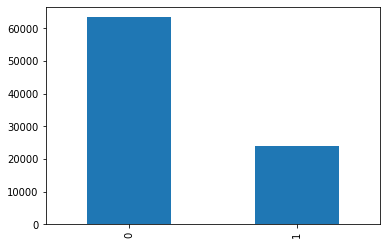

In [7]:
df.is_canceled.value_counts().plot.bar()

- If 'is_canceled' is target model, it's unbalanced.

In [8]:
# convert month name to month number
df.arrival_date_month = df.arrival_date_month.apply(lambda m:datetime.datetime.strptime(m, '%B').month)

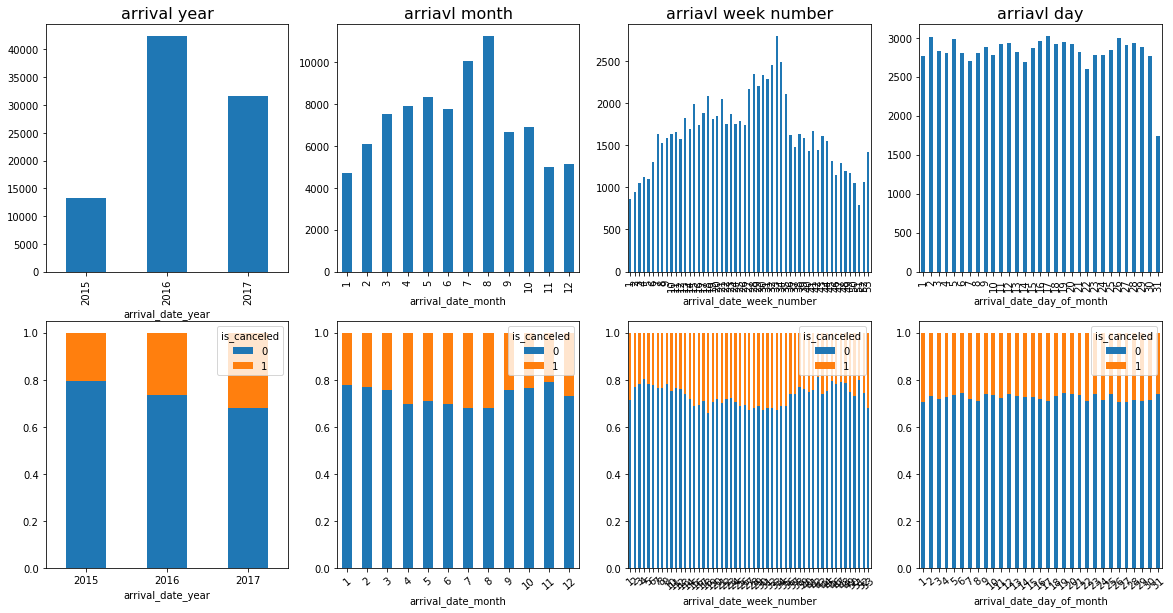

In [9]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))
df.groupby('arrival_date_year')['adr'].count().plot.bar(ax = axes[0][0])
df.groupby('arrival_date_month')['adr'].count().plot.bar(ax = axes[0][1])
df.groupby('arrival_date_week_number')['adr'].count().plot.bar(ax = axes[0][2])
df.groupby('arrival_date_day_of_month')['adr'].count().plot.bar(ax = axes[0][3])

axes[0][0].set_title('arrival year', fontsize = 16)
axes[0][1].set_title('arriavl month', fontsize = 16)
axes[0][2].set_title('arriavl week number', fontsize = 16)
axes[0][3].set_title('arriavl day', fontsize = 16)

temp = pd.pivot_table(df, index='arrival_date_year', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=0, stacked=True, ax=axes[1][0]);

temp = pd.pivot_table(df, index='arrival_date_month', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=40, stacked=True, ax=axes[1][1]);

temp = pd.pivot_table(df, index='arrival_date_week_number', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=40, stacked=True, ax=axes[1][2]);

temp = pd.pivot_table(df, index='arrival_date_day_of_month', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=40, stacked=True, ax=axes[1][3])

- 2016 had the most bookings, 2015 had the least boookings.
- 2017 had higher cancellation rate than 2015 and 2016.
- July and August had more bookings than other months.
- `arrival_date_month` and `arrival_date_week_number` had silmilar pattern, maybe ther are highly correlated, only one of them should be kept.
- No obvious pattern in day of the month.

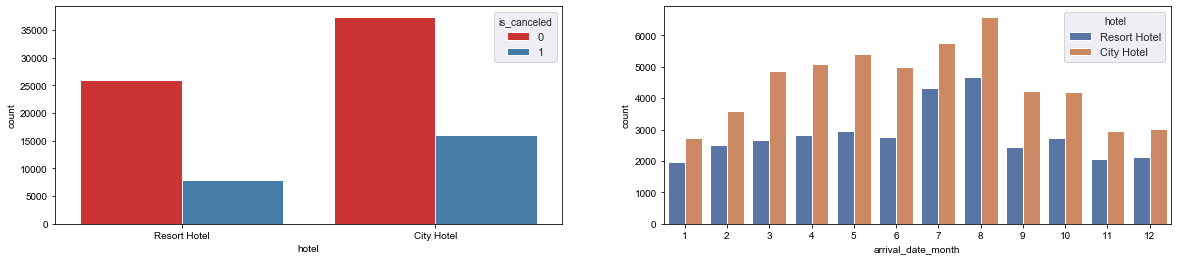

In [10]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4))
sns.set(style='darkgrid')
sns.countplot(x='hotel', hue='is_canceled', data=df, ax=axes[0], palette='Set1')
sns.countplot(x='arrival_date_month', hue='hotel', data=df,ax=axes[1])

- City hotel had a higher cancellation rate than resort hotel.
- City hotel had more booking tha resort hotel every month.

Text(0.5, 1.0, 'Average Daily Rate by hotel type')

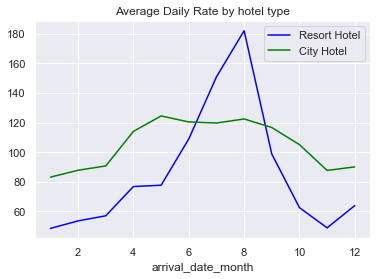

In [11]:
df_notCancel = df[df.is_canceled == 0]
df_notCancel[df_notCancel.hotel=='Resort Hotel'].groupby('arrival_date_month').mean()['adr'].plot(color='blue', label='Resort Hotel')
df_notCancel[df_notCancel.hotel=='City Hotel'].groupby('arrival_date_month').mean()['adr'].plot(color='green', label='City Hotel')
plt.legend()
plt.title('Average Daily Rate by hotel type')

- Here only not-cancelled bookings were considered.
- Price of Resort Hotel was affected by sesonality.
- Price of City Hotel was higher than resort hotel except July to September.

Text(0.5, 1.0, 'Average Daily Rate by Month')

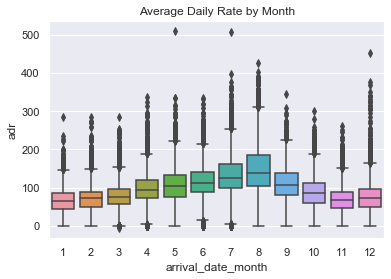

In [12]:
df_notCancel[['arrival_date_month', 'adr']]
sns.boxplot(x='arrival_date_month',
            y='adr',
            data=df_notCancel)
plt.title('Average Daily Rate by Month')

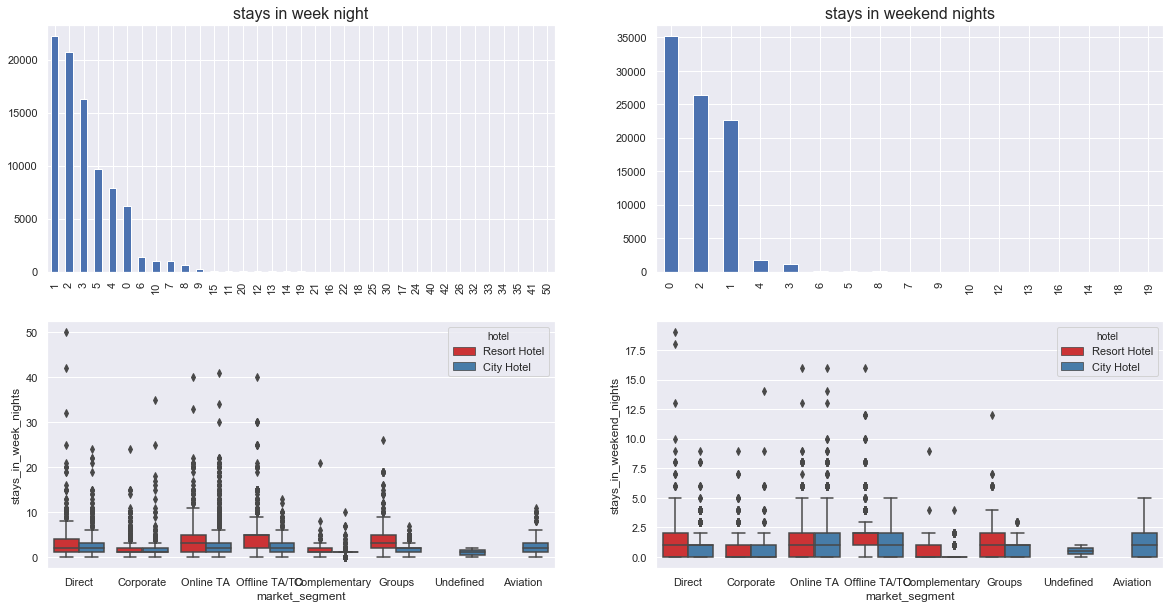

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
df.stays_in_week_nights.value_counts().plot.bar(ax=axes[0][0])
df.stays_in_weekend_nights.value_counts().plot.bar(ax=axes[0][1])
axes[0][0].set_title('stays in week night', fontsize=16)
axes[0][1].set_title('stays in weekend nights', fontsize=16)

sns.boxplot(x='market_segment', y='stays_in_week_nights', data=df, hue='hotel', ax=axes[1][0], palette='Set1')
sns.boxplot(x='market_segment', y='stays_in_weekend_nights', data=df, hue='hotel', ax=axes[1][1], palette='Set1')

**Check stay nights by weekday and weekend.**
- There're outliers in 'stays in weekend night' and 'stays in week night'.
- Most of booking's 'stays in weekend night' was less than 6.
- Most of booking's 'stays in week night' was less than 11.

**Check stay nights by hotel type.**
- As for market segment 'Online TA', csutomers with weekday resort hotel booking had higher variability than weekday city hotel booking in the stay nights, but, weekend booking had similar distribution.
- As for market segment 'Offline TA/TO', csutomers with weekday resort hotel booking had higher variability than weekday city hotel booking in the stay nights, but, the results were opposite in weekend booking.

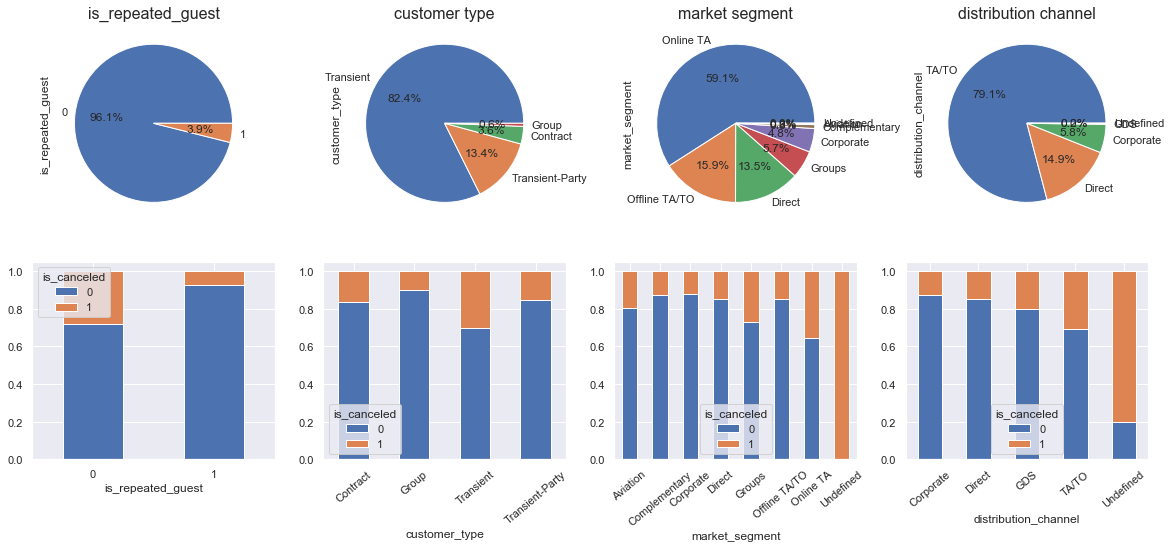

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,8))

df.is_repeated_guest.value_counts().plot.pie(ax=axes[0][0], autopct='%1.1f%%')
df.customer_type.value_counts().plot.pie(ax=axes[0][1], autopct='%1.1f%%')
df.market_segment.value_counts().plot.pie(ax=axes[0][2], autopct='%1.1f%%')
df.distribution_channel.value_counts().plot.pie(ax=axes[0][3], autopct='%1.1f%%')
axes[0][0].set_title('is_repeated_guest', fontsize=16)
axes[0][1].set_title('customer type', fontsize=16)
axes[0][2].set_title('market segment', fontsize=16)
axes[0][3].set_title('distribution channel', fontsize=16)

temp = pd.pivot_table(df, index='is_repeated_guest', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=0, stacked=True, ax=axes[1][0]);

temp = pd.pivot_table(df, index='customer_type', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=40, stacked=True, ax=axes[1][1]);

temp = pd.pivot_table(df, index='market_segment', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=40, stacked=True, ax=axes[1][2]);

temp = pd.pivot_table(df, index='distribution_channel', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=40, stacked=True, ax=axes[1][3])

**As for repeat guests:**
- 96.1% of the bookings were not repeated guests. 
- The cancellation rate of non-repeating guest was higher than repeating guests.

**As for guests from different customer types:**
- More than 80% of bookings were transient clients. Only a small number of bookings were group clients.
- The cancellation rate of transient guest was higher than other types.

**As for guests from different market segments:**
- The biggest market, almost 60%, was Online TA, the next two segments were offline TA/TO(16%) and Direct(13.5%).
- The cancellation rate of Online TA was higher than other segments.
- The cancellation rate of Undefined guests were 100%, but there're only two guests in this group, which was not informative.

**As for guests from different distribution channels:**
- The biggest distribution channel was TA/TO, which was almost 80%.
- The information provided by 'market segment' and 'distribution channel' were similar, maybe we can drop one of them.
- Note TA meant Travel Agents, TO meant Tour operators.

Text(0.5, 1.0, 'num of babies')

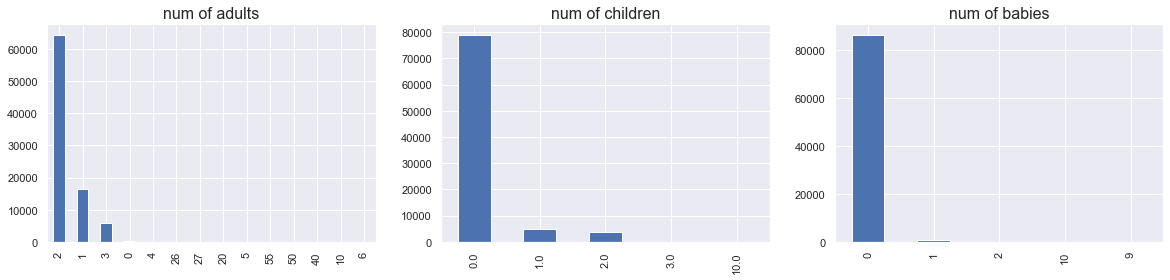

In [15]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 4))
df.adults.value_counts().plot.bar(ax = axes[0])
df.children.value_counts().plot.bar(ax = axes[1])
df.babies.value_counts().plot.bar(ax = axes[2])
axes[0].set_title('num of adults', fontsize = 16)
axes[1].set_title('num of children', fontsize = 16)
axes[2].set_title('num of babies', fontsize = 16)

- Most of bookings had num of adults less than 5.
- Most of bookings had children less than 4. 10 might be an outlier.
- Most of bookings had num of babies less than 2.
- Need to check if there're booking with 0 adult, 0 children and 0 baby.

In [16]:
df[
    (df.adults == 0) 
    & (df.children == 0) 
    & (df.babies == 0)
].is_canceled.value_counts()

0    150
1     16
Name: is_canceled, dtype: int64

- The bookings without people may be caused by mannual inputing, these observations would be removed.

Text(0.5, 1.0, 'company')

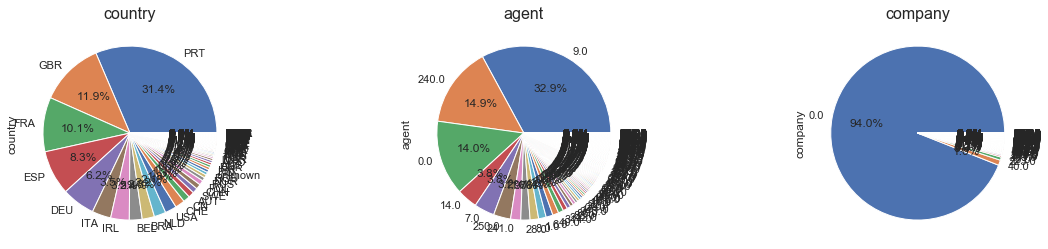

In [17]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 4))
df.country.value_counts().plot.pie(ax=axes[0], autopct='%1.1f%%')
df.agent.value_counts().plot.pie(ax=axes[1], autopct='%1.1f%%')
df.company.value_counts().plot.pie(ax=axes[2], autopct='%1.1f%%')
axes[0].set_title('country', fontsize=16)
axes[1].set_title('agent', fontsize=16)
axes[2].set_title('company', fontsize=16)

**Where did gueats come from?**
- More than half of the bookings were maily from PRT, GBR and FRA.

**What agent did the guests use?**
- More than half of the bookings were maily from agent 9, 240 and 0(no agent).

**Are they company guests?**
- More that 90% of bookings were not company clients.

Text(0.5, 1.0, 'booking_changes')

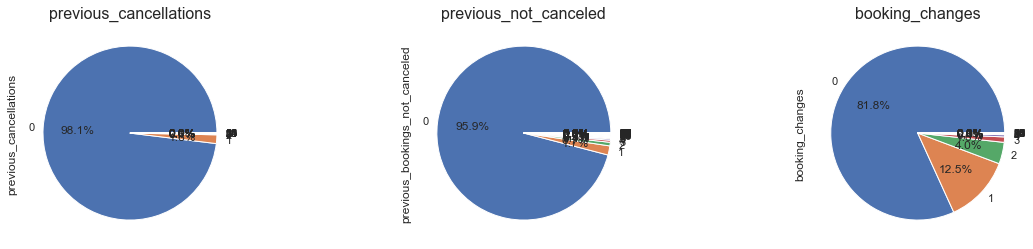

In [18]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 4))

df.previous_cancellations.value_counts().plot.pie(ax=axes[0], autopct='%1.1f%%')
df.previous_bookings_not_canceled.value_counts().plot.pie(ax=axes[1], autopct='%1.1f%%')
df.booking_changes.value_counts().plot.pie(ax=axes[2], autopct='%1.1f%%')

axes[0].set_title('previous_cancellations', fontsize=16)
axes[1].set_title('previous_not_canceled', fontsize=16)
axes[2].set_title('booking_changes', fontsize=16)

- 98.1% of the bookings didn't cancelled before.
- 81% of the guests didn't change their bookings.
- In `previous_not_canceled`, 0 means no customer profile was associated with the booking, we may assume these customers were new guests.

In [19]:
df.groupby('is_canceled').previous_cancellations.mean()

is_canceled
0    0.018715
1    0.061270
Name: previous_cancellations, dtype: float64

In [20]:
df.groupby('is_canceled').previous_cancellations.value_counts()

is_canceled  previous_cancellations
0            0                         62830
             1                           336
             2                            78
             3                            45
             11                           25
             4                            24
             5                            17
             6                            15
             13                            1
1            0                         22881
             1                          1071
             2                            34
             3                            16
             4                             6
             13                            3
             5                             2
             6                             2
             11                            2
             24                            2
             25                            2
             14                            1
             19    

- There're outliers to remove in feature `previous_cancellations`. May need mannual set threshold .

In [21]:
# check reservation_status
df.groupby('is_canceled').reservation_status.value_counts()

is_canceled  reservation_status
0            Check-Out             63371
1            Canceled              23011
             No-Show                1014
Name: reservation_status, dtype: int64

- The feature `reservation_status` should be excluded, seeing as all the not calcelled booking with a 'Check-Out' reservation status.

In [22]:
new_user_pct = df[(df.previous_bookings_not_canceled==0) & (df.previous_cancellations==0)].shape[0]/df.shape[0]
new_user_pct

0.9473431278319374

- 0 means there was no customer profile associated with the booking.
- 95% of the bookings are from new customers.

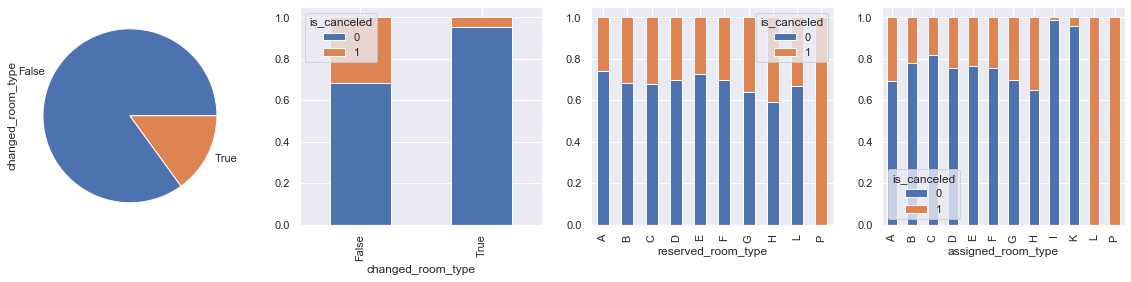

In [23]:
# check 'reserved_room_type' and 'assigned_room_type'
df['changed_room_type'] = df.reserved_room_type!=df.assigned_room_type

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
df.changed_room_type.value_counts().plot.pie(ax=axes[0])
temp = pd.pivot_table(df, index='changed_room_type', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(stacked=True, ax=axes[1])

temp = pd.pivot_table(df, index='reserved_room_type', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(stacked=True, ax=axes[2])

temp = pd.pivot_table(df, index='assigned_room_type', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(stacked=True, ax=axes[3])

- Generate a new feature to show if assigned room type is same as reserved room type.
- Some times assigned room type differs from the reserved room type due to hotel operation reasons(e.g overbooking) or by customer request.
- If we know detailed meaning of room type ,we can go further here, such as if assigned room type is different from reserved room type, but hotel assigned a better room to customer, which maybe helpful to reduce cancellation.
- Even though assign room type 'L' showed overall cancelation rate, but the data size was really small, which couldn't be a strong indicator.

Text(0.5, 1.0, 'cancellation pct with booking changes')

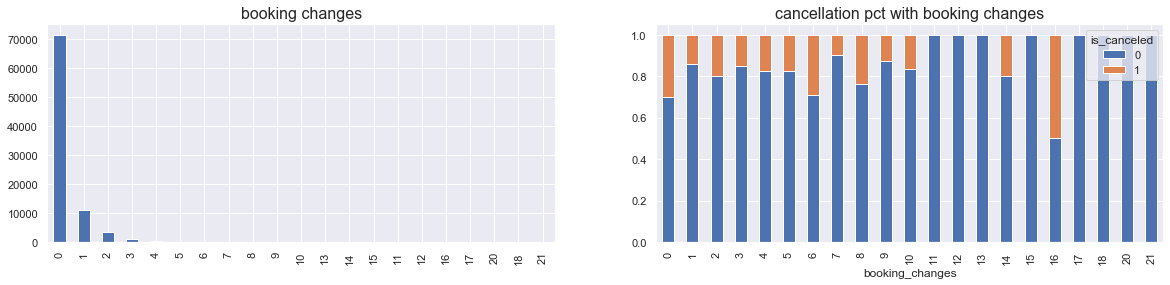

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
df.booking_changes.value_counts().plot.bar(ax=axes[0])

temp = pd.pivot_table(df, index='booking_changes', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(stacked=True, ax=axes[1])
axes[0].set_title('booking changes', fontsize=16)
axes[1].set_title('cancellation pct with booking changes', fontsize=16)

In [25]:
df[(df.booking_changes==0) | (df.booking_changes==1)].shape[0]/df.shape[0]

0.9427891436679025

- `booking_changes` included changes of booking attributes,namely, persons, arrival date, nights, reserved room type or meal;
- 'no change' and 'change once' were more than 90% in all booking records.
- Bookings with once change had lower cancellation rate than bookings without change. Maybe because the guests double checked if they wanted to come before they made the change.

Text(0.5, 1.0, 'calcellation per number_of_lead_weeks')

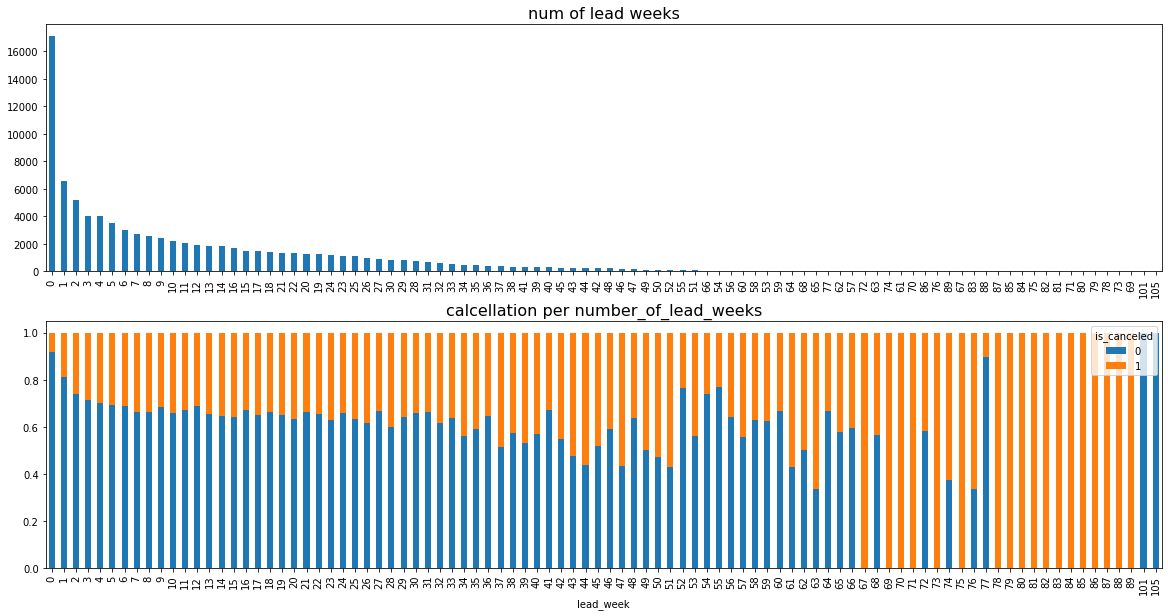

In [10]:
# check lead time, generate new feature 'lead week'
df['lead_week'] = (df.lead_time/7).astype('int')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
df.lead_week .value_counts().plot.bar(ax=axes[0])

temp = pd.pivot_table(df, index='lead_week', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(stacked=True, ax=axes[1])

axes[0].set_title('num of lead weeks', fontsize=16)
axes[1].set_title('calcellation per number_of_lead_weeks', fontsize=16)

- 20% of bookings with lead time less than 1 week, about 7% bookings with lead time less than 2 weeks, the former one had lower cancellation rate than later one.

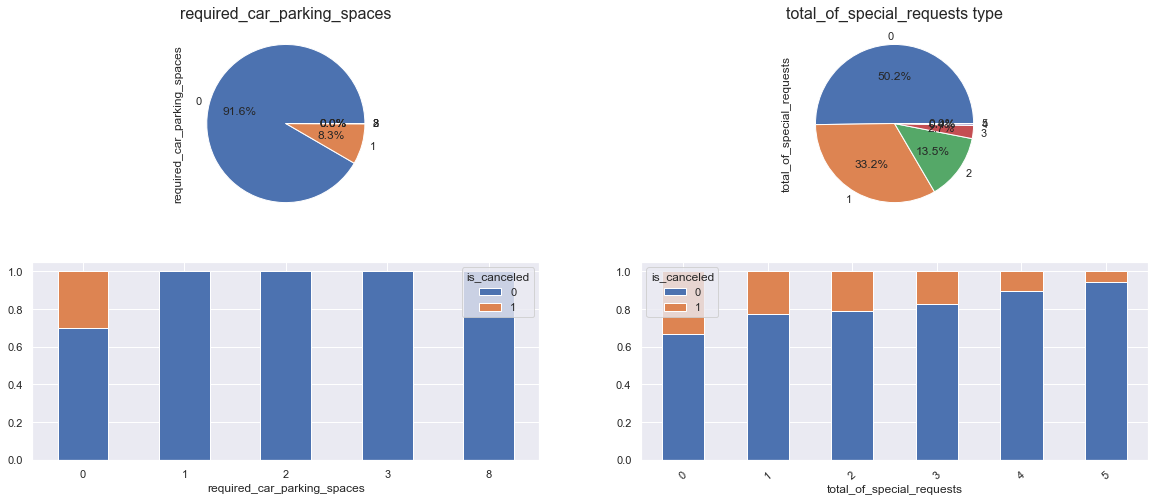

In [27]:
# check required_car_parking_spaces, total_of_special_requests
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,8))

df.required_car_parking_spaces.value_counts().plot.pie(ax=axes[0][0], autopct='%1.1f%%')
df.total_of_special_requests.value_counts().plot.pie(ax=axes[0][1], autopct='%1.1f%%')

axes[0][0].set_title('required_car_parking_spaces', fontsize=16)
axes[0][1].set_title('total_of_special_requests type', fontsize=16)

temp = pd.pivot_table(df, index='required_car_parking_spaces', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=0, stacked=True, ax=axes[1][0]);

temp = pd.pivot_table(df, index='total_of_special_requests', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(rot=40, stacked=True, ax=axes[1][1]);

- More than 90% of bookings didn't require car parking space. 
- Bookings with parking spaces didn't cancel, but the data size was only 10%.
- Bookings with special requests had lower cancelation rate than bookings without special requests.

In [28]:
df.deposit_type.value_counts()

No Deposit    86251
Non Refund     1038
Refundable      107
Name: deposit_type, dtype: int64

Text(0.5, 1.0, 'cancellation pct with deposit_type')

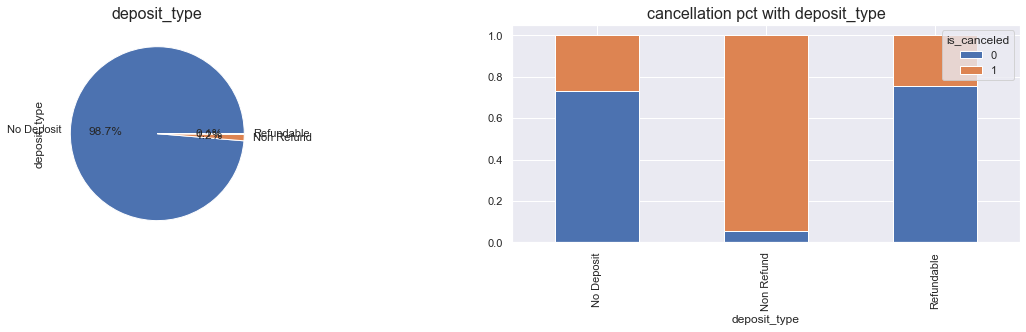

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
df.deposit_type.value_counts().plot.pie(ax=axes[0], autopct='%1.1f%%')

temp = pd.pivot_table(df, index='deposit_type', columns='is_canceled', aggfunc='count')['adr']
temp.div(temp.sum(axis=1), axis=0).plot.bar(stacked=True, ax=axes[1])
axes[0].set_title('deposit_type', fontsize=16)
axes[1].set_title('cancellation pct with deposit_type', fontsize=16)

- The cancellation rate was very high with Non-refund customers, but the sample size was too small.

### Drop bookings with 0 guests

In [30]:
# Drop bookings with 0 people.
df = df[~((df.adults==0) & (df.children==0) & (df.babies==0))]
df.shape

(87230, 34)

In [31]:
# check correlations between numerical features, which numerical features are most important?
cancel_corr = df.corr()['is_canceled']
cancel_corr.abs().sort_values(ascending=False)

is_canceled                       1.000000
changed_room_type                 0.213363
lead_time                         0.184515
required_car_parking_spaces       0.184456
lead_week                         0.183641
adr                               0.127233
total_of_special_requests         0.120794
booking_changes                   0.093236
is_repeated_guest                 0.088764
arrival_date_year                 0.088020
stays_in_week_nights              0.084159
adults                            0.080271
company                           0.075314
children                          0.067182
stays_in_weekend_nights           0.060992
previous_bookings_not_canceled    0.052178
previous_cancellations            0.051501
babies                            0.020627
arrival_date_day_of_month         0.005449
days_in_waiting_list              0.004710
arrival_date_month                0.003954
arrival_date_week_number          0.001691
agent                             0.001145
Name: is_ca

- From this list it is apparent that `lead_time`, `required_car_parking_spaces`, `adr`, `total_of_special_requests`, `booking_changes` are the 5 most important numerical features.

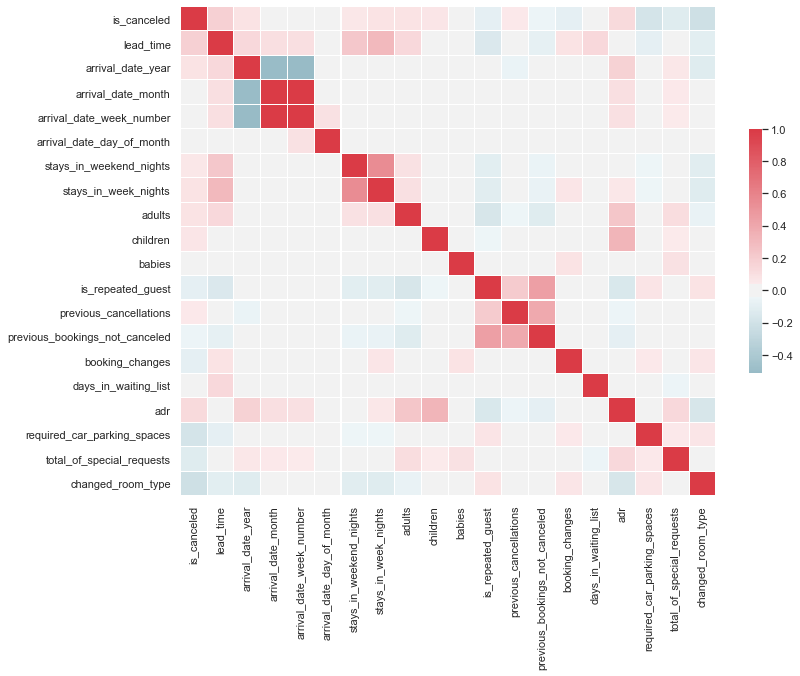

In [55]:
# 'company', 'agent' and 'lead_week' were drop while checking correlation.
# The number of 'company' and 'agent' were pseudo code. 
# 'lead_week' is same as 'leading_time'.
f, ax = plt.subplots(figsize=(12, 9))
ax = sns.heatmap(
                df.drop(columns=['company', 'agent', 'lead_week']).corr(),
                cmap = sns.diverging_palette(220, 10, as_cmap=True),
                center=0, 
                square=False,
                linewidths=.1,
                cbar_kws={'shrink':0.5})

- (`arrival_date_week_number` and `arrival_date_month`): they were highly correlated to each other.
- (`stays_in_week_nights`, `stays_in_weekend_nights`): when a guest stays long, like one week, then of course both variables will increase simultaneously.
- (`stays_in_week_nights`, `lead_time`), (`stays_in_weekend_nights`, `lead_time`): the more stay in week or weekend nights, the higher lead time.
- (`previous_bookings_not_canceled`, `is_repeated_guest`): repeated guest had previous not calcellation larger than 0. It is worth mention that the correlation of (`is_repeated_guest`, `previous_bookings_canceled`) was much smaller than (`is_repeated_guest`, `previous_bookings_not_canceled`), which indicated repeated guest tended not to cancel a booking.
- (`adr`, `children`), (`adults`, `children`): the more children or adults, the higher average daily rate.

In [7]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,0.0,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,0.0,0.0,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,0.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,0.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,0.0,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [9]:
df.select_dtypes(include=[np.number]).columns

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')

In [14]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'lead_week'],
      dtype='object')

# Data Process

In [49]:
###
# cleaning
###

def drop_duplicates(df):
    df_no_dup = df.drop_duplicates()
    return df_no_dup

def missing_imputation(df):
    nan_replacements = {'children': 0, 'country': 'unknown', 'agent': 0, 'company': 0}
    df_no_missing = df.fillna(nan_replacements)
    return df_no_missing
    
def drop_high_corr(df):
    df_rm_corr = df.drop(columns=['reservation_status', 'reservation_status_date'])
    return df_rm_corr

def change_type(df):
    df.agent = df.agent.astype('str')
    df.company = df.company.astype('str')
    return df
    
def transform_month(df):
    df.arrival_date_month = df.arrival_date_month.apply(lambda m:datetime.datetime.strptime(m, '%B').month)
    return df
    
def cleaning(df):
    # drop_duplicates
    df_no_dup = drop_duplicates(df)
    # drop columns not used for cancelation prediction
    df_rm_corr = df_no_dup.drop(columns=['reservation_status', 'reservation_status_date'])
    # missing values imputation
    df_no_missing = missing_imputation(df_rm_corr)
    # change data type
    df_no_missing = change_type(df_no_missing)
    return df_no_missing

In [50]:
process_data = cleaning(df)
target = 'is_canceled'

# features and target
features = process_data.columns.tolist()
features.remove(target)

X, y = df[features], df[target]

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=[np.object]).columns.tolist()

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')
print(f'\nnumeric features: {len(num_features)}\n{num_features}')
print(f'\ncategorical features: {len(cat_features)}\n{cat_features}')

Shape of X: (87396, 30)
Shape of y: (87396,)

numeric features: 20
['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'lead_week']

categorical features: 10
['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']


# Modeling

### Customer / Booking Segmentation

Before booking cancelation prediction, customer (or booking records) segmentation would be performed first. The purpose of customer segmentation are as following:

- Group customers into distinct segments to extract the characteristics of each groups. Get more insights on the behaviours of different types of customers, which would help to establish operations strategies.
- Add a new feature `customer_segment` for cancelation prediction. As part of feature engineering, the new label is expected to provide more insights on customers. It will be discussed at the end of the section.

In [ ]:
# only numerical features were use for clustering

# 